# IQS Data Explorer Example

This notebook demonstrates how to use the unified configuration system with the Text2Cypher workflow to analyze Honda vehicle customer feedback data.

In [1]:
import sys

# Add the project root to Python path
sys.path.append("../..")

In [2]:
from dotenv import load_dotenv
from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI

from neo4j_text2cypher.retrievers.cypher_examples import UnifiedConfigCypherExampleRetriever
from neo4j_text2cypher.utils.config import UnifiedAppConfigLoader
from neo4j_text2cypher.workflows.neo4j_text2cypher_workflow import create_neo4j_text2cypher_workflow
from neo4j_text2cypher.utils.debug import setup_debug_logging

In [3]:
# Load environment variables
load_dotenv()

True

## Initialize Components

Load configuration and set up the Neo4j graph connection, LLM, and unified Cypher example retriever.

In [5]:
# Load unified configuration
config_path = "app-config.yml"
config_loader = UnifiedAppConfigLoader(config_path)

# debug logging based on config
debug_config = config_loader.get_debug_config()
setup_debug_logging(debug_config)

# Initialize Neo4j graph connection (uses environment variables)
graph = Neo4jGraph(enhanced_schema=True)
print("Connected to Neo4j")
print(f"Schema: {graph.schema[:500]}...")  # Print first 500 chars of schema

Connected to Neo4j
Schema: Node properties:
- **Customer**
  - `id`: STRING Example: "9A79438B"
  - `ageBucket`: STRING Example: ">=70"
  - `gender`: STRING Available options: ['Male', 'Female', '']
- **Category**
  - `id`: STRING Available options: ['Exterior', 'Driving Experience', 'Features/Controls/Displays (FCD)', 'Driving Assistance', 'Infotainment', 'Seats', 'Climate', 'Interior', 'Powertrain']
- **Problem**
  - `id`: STRING Example: "EXT01"
  - `problem`: STRING Example: "EXT01: Doors - Hard to open/close"
- **Que...


In [6]:
# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)
print("LLM initialized")

LLM initialized


In [7]:
# Initialize unified Cypher example retriever
cypher_example_retriever = UnifiedConfigCypherExampleRetriever(config_path=config_path)

# Get Streamlit configuration for scope description
streamlit_config = config_loader.get_streamlit_config()
print(f"Loaded {len(config_loader.get_example_queries())} example queries from: {config_path}")
print(f"App: {streamlit_config.title}")
print(f"Scope: {streamlit_config.scope_description[:100]}...")

Loaded 16 example queries from: app-config.yml
App: IQS Data Explorer
Scope: This application may answer questions related to customer feedback on Honda vehicles....


## Create the Workflow

Set up the text2cypher workflow using the unified configuration system.

In [8]:
# Create the workflow using unified configuration
agent = create_neo4j_text2cypher_workflow(
    llm=llm,
    graph=graph,
    scope_description=streamlit_config.scope_description,
    cypher_example_retriever=cypher_example_retriever,
    llm_cypher_validation=True,
    max_attempts=3,
    attempt_cypher_execution_on_final_attempt=False,
    enable_final_answer_validation=False
)

print("Text2Cypher workflow created successfully!")
print(f"Configuration loaded from: {config_path}")

Text2Cypher workflow created successfully!
Configuration loaded from: app-config.yml


## Visualize the Workflow

Display the workflow graph to understand the execution flow.

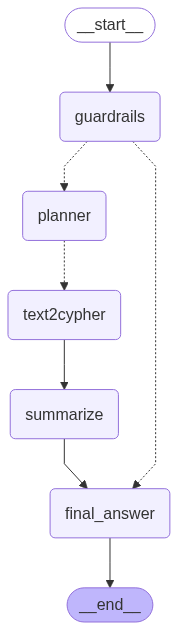

In [9]:
from IPython.display import Image, display

try:
    # Display the workflow graph
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Workflow structure:")
    print("Input → Guardrails → Planner → Text2Cypher → Summarize → Validate → Final Answer")

Visualization below with more detail on the Text2Cypher component

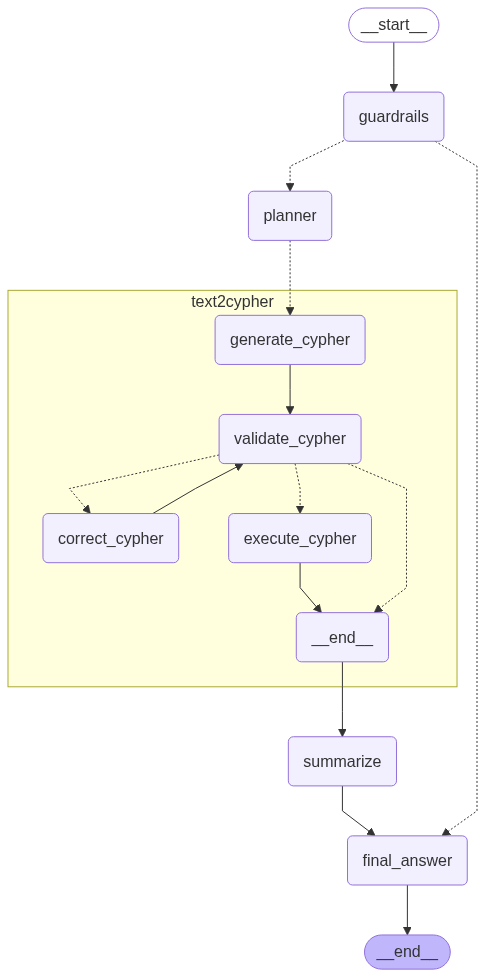

In [10]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [11]:
# Test conversation history with manual tracking
from neo4j_text2cypher.components.state import HistoryRecord, CypherHistoryRecord

# Initialize empty conversation history
conversation_history = []

question = "How many responses are under Honda Civic?"

# First question
print("=== FIRST QUESTION ===")
response = await agent.ainvoke({
    "question": question,
    "data": [],
    "history": conversation_history
})

print(f"Answer: {response.get('answer', 'No answer')}")
print(f"Cyphers executed: {len(response.get('cyphers', []))}")

# Add to conversation history
if response.get('cyphers'):
    history_record = HistoryRecord(
        question=question,
        answer=response.get('answer', ''),
        cyphers=[CypherHistoryRecord(
            task=cypher.get('task', ''),
            statement=cypher.get('statement', ''),
            records=cypher.get('records', [])
        ) for cypher in response.get('cyphers', [])]
    )
    conversation_history.append(history_record)
    print(f"✅ Added to history. History length: {len(conversation_history)}")
else:
    print("❌ No cyphers to add to history")

=== FIRST QUESTION ===
Answer: There are 965 responses under Honda Civic.
Cyphers executed: 1
✅ Added to history. History length: 1


In [12]:
# Follow-up question with history
print("\n=== FOLLOW-UP QUESTION WITH HISTORY ===")
question = "Can you summarize responses related to doors for that same vehicle?"

response = await agent.ainvoke({
    "question": question,
    "data": [],
    "history": conversation_history
})

print(f"Answer: {response.get('answer', 'No answer')}")
print(f"Steps: {response.get('steps', [])}")
print(f"Cyphers executed: {len(response.get('cyphers', []))}")

# Debug output
for i, cypher in enumerate(response.get('cyphers', [])):
    print(f"\nCypher {i+1}:")
    print(f"  Task: {cypher.get('task', 'No task')}")
    print(f"  Statement: {cypher.get('statement', 'No statement')}")
    print(f"  Records: {len(cypher.get('records', []))} records")
    if cypher.get('errors'):
        print(f"  Errors: {cypher.get('errors')}")


=== FOLLOW-UP QUESTION WITH HISTORY ===
Answer: - Black cloth seats and door panels show dirt, lint, and scuffs easily.
- Driver's seat belt adjustment mechanism and B-pillar area can rattle.
- Door trim issues include improper installation and rattling when windows are down.
- Cupholders are insufficient and do not fit certain brands of insulated bottles.
- Interior materials, including door panels and armrests, are prone to scuffing and scratching.
- Door seals may be loose, causing water leaks and requiring more force to close doors.
- Inconsistent door locking and unlocking behavior, with some doors not unlocking as expected.
- Issues with the fuel door being difficult to open or opening too easily.
- Body panel misalignments, including gaps in doors and hood.
- Wind noise and water pooling in door sills during rain or car washes.
- Problems with pairing garage door openers and insufficient range for push start.
Steps: ['guardrails', 'planner', ['generate_cypher', 'validate_cypher

## Example Usage

Run some example questions from the configuration through the workflow.

In [ ]:
# Use the first example question from configuration
question = streamlit_config.example_questions[0]
print(f"Testing with example question: {question}")

response = await agent.ainvoke({
    "question": question,
    "data": [],
    "history": []
})

print(f"Question: {response.get('question')}")
print(f"\nAnswer: {response.get('answer')}")

## Examine the Results

Look at the generated Cypher queries and execution steps.

In [ ]:
# Display the execution steps
print("Execution Steps:")
for step in response.get("steps", []):
    print(f"  - {step}")

In [ ]:
# Display generated Cypher queries and results
cyphers = response.get("cyphers", [])
print(f"\nGenerated {len(cyphers)} Cypher queries:")

for i, cypher_result in enumerate(cyphers):
    print(f"\n--- Query {i+1} ---")
    print(f"Task: {cypher_result.get('task')}")
    print(f"Cypher: {cypher_result.get('statement')}")
    
    records = cypher_result.get('records', [])
    print(f"Results: {len(records)} records")
    
    # Show first few records
    for j, record in enumerate(records[:3]):
        print(f"  Record {j+1}: {record}")
    
    if len(records) > 3:
        print(f"  ... and {len(records) - 3} more records")

## Try Your Own Questions

You can also try any of the example questions from the configuration or create your own.

In [ ]:
# Show available example questions
print("Available example questions from configuration:")
for i, q in enumerate(streamlit_config.example_questions[:5], 1):
    print(f"{i}. {q}")

# Try one of the Honda-specific questions
my_question = streamlit_config.example_questions[1]  # Use second example question
print(f"\nTesting question: {my_question}")

my_response = await agent.ainvoke({
    "question": my_question,
    "data": [],
    "history": []
})

print(f"\nAnswer: {my_response.get('answer')}")

# Show Cypher queries
my_cyphers = my_response.get("cyphers", [])
for cypher_result in my_cyphers:
    print(f"\nCypher: {cypher_result.get('statement')}")
    records = cypher_result.get('records', [])
    if records:
        print(f"Result: {records[0] if records else 'No results'}")